## Conexão com o Bucket (Leia o comentário)

In [ ]:
"""
Essa célula foi rodada para fazer o treinamento do modelo com os dados reais, porém como o bucket não está público
ela só funciona conectada às contas permissionadas do nosso projeto.

Para fins de teste e para que todos consigam rodar, disponibilizamos alguns dados, basta apenas ignorar essa célula
"""
import pandas as pd
from io import BytesIO
import os

# Autenticação do Colab
from google.colab import auth
auth.authenticate_user()

# Acessa o Cloud Storage
from google.cloud import storage
client = storage.Client()

# Obtem as variáveis de ambiente
BUCKET_NAME = os.environ.get("BUCKET_NAME")
FOLDER_PATH = os.environ.get("FOLDER_PATH")

bucket_name = "BUCKET_NAME"
folder_path = "FOLDER_PATH"
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=folder_path)  # Lista todos os arquivos na pasta


# -------- Cria o Dataframe com os dados reais ------

dfs_tratados = []

# Iterar sobre os arquivos CSV encontrados no bucket
for blob in blobs:
    if blob.name.endswith(".CSV"):
        content = blob.download_as_bytes()

        # Dataframe de regiões
        df_tratado = pd.read_csv(BytesIO(content), encoding="latin-1", sep=",")

        dfs_tratados.append(df_tratado)


inmet_gold = pd.concat(dfs_tratados, ignore_index=True)

## Criação do Dataframe (Dados para teste)

In [1]:
import pandas as pd
import glob

# Rastreia os arquivos de teste
folder_path = "Dados_de_teste/"
test_files = glob.glob(folder_path + "/*.CSV")

# Cria uma lista para armazenar Dataframes dos arquivos de teste
dfs = [pd.read_csv(f) for f in test_files]

# Concatena todos os DataFrames em um único
inmet_gold = pd.concat(dfs, ignore_index=True)

## Modelo Random forest

In [2]:
!pip install imblearn
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) # coluna
pd.set_option('display.max_rows', None) # linha

pd.set_option('display.max_rows', None) # linha

In [4]:
# Análise da quantidade de dados em cada classe preditiva (Geada e não geada)
# Atravéz dessa análise, verificamos que a quantidade de dados está muito desbalanceada
# Para solucionar vamos usar algoritimos de Under Scalling e Over Scalling

qtd_geada = len(inmet_gold[inmet_gold['Geada-OBS'] == 1])
qtd_nao_geada = len(inmet_gold[inmet_gold['Geada-OBS'] == 0])

print(f'Quantidade de geadas: {qtd_geada}')
print(f'Quantidade de não geadas: {qtd_nao_geada}')

Quantidade de geadas: 79
Quantidade de não geadas: 64169


In [5]:
# Definindo as variávesis de preditoras e alvo para treinamento e teste do modelo Random Forest
# Variáveis preditoras: referem-se as variáveis meteorológicas que descrevem o fenômeno de geada
# Variável alvo: refere-se a variável de ocorrência de geada.

# Preparando os dados com TODAS as amostras
X = inmet_gold[['T.MIN', 'UR.MED', 'VT.MED', 'PREC']]
y = inmet_gold['Geada-OBS']

# Under-Sampling na classe majoritária
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_under, y_under = under_sampler.fit_resample(X, y)

# Over-Sampling (SMOTE) na classe minoritária
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)


# Dividindo os dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42)


In [6]:
# Criando e treinando o modelo
modelo_RF = RandomForestClassifier(n_estimators=70, max_depth=5, random_state=42)
modelo_RF.fit(X_treino, y_treino)

RandomForestClassifier(max_depth=5, n_estimators=70, random_state=42)

In [7]:
# Prevendo e avaliando
y_prev = modelo_RF.predict(X_teste)
acuracia = accuracy_score(y_teste, y_prev)
relatorio = classification_report(y_teste, y_prev, output_dict=True)
relatorio_df = pd.DataFrame(relatorio).transpose()
relatorio_df['Acurácia Geral'] = acuracia

# Adiciona as previsões ao DataFrame original
inmet_gold['y_prev'] = modelo_RF.predict(X)

# Calcular R² Score
r2 = r2_score(y_teste, y_prev)

# Renomear a coluna no DataFrame principal
inmet_gold.rename(columns={"y_prev": "Geada_prev"}, inplace=True)

# Adicionar R² ao final do relatório
relatorio_df['R2_Score'] = ""
relatorio_df.loc['R2_Score'] = [""] * (relatorio_df.shape[1] - 1) + [r2]

# Substituir índices 0 e 1 por descrições mais claras
relatorio_df = relatorio_df.rename(index={"0": "Sem Geada", "1": "Com Geada"})

# Formatar como percentual com 1 casa decimal, exceto campos de suporte e strings
def formatar_percentual(valor, coluna):
    if isinstance(valor, (int, float)) and coluna != 'support' and not pd.isnull(valor):
        return f"{valor * 100:.1f}%"
    return valor

relatorio_final = relatorio_df.copy()
for col in relatorio_final.columns:
    relatorio_final[col] = relatorio_final[col].apply(lambda x: formatar_percentual(x, col))

display(relatorio_final)

,precision,recall,f1-score,support,Acurácia Geral,R2_Score
Sem Geada,94.0%,97.9%,95.9%,48.0,95.8%,
Com Geada,97.8%,93.6%,95.7%,47.0,95.8%,
accuracy,95.8%,95.8%,95.8%,0.957895,95.8%,
macro avg,95.9%,95.8%,95.8%,95.0,95.8%,
weighted avg,95.9%,95.8%,95.8%,95.0,95.8%,
R2_Score,,,,,,83.2%


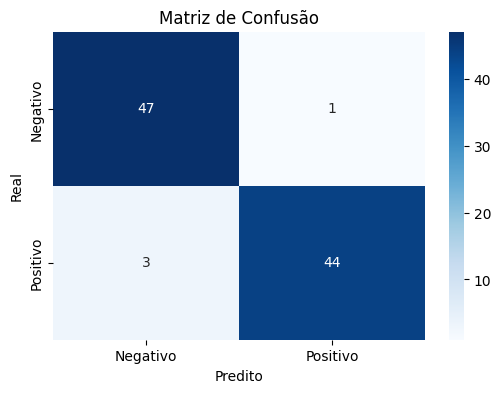

In [8]:
# Gera a matriz de confusão
cm = confusion_matrix(y_teste, y_prev)

# Plota o gráfico na tela
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

## Output do modelo (Excel)

In [9]:
# Criar dicionário explicativo dos termos usados no relatório
explicacoes = {
    "Termo": ["precision", "recall", "f1-score", "support", "accuracy", "macro avg", "weighted avg"],
    "Descrição": [
        "Precisão: Entre os casos que o modelo previu como positivos (ex: geada), quantos realmente são positivos? Fórmula: TP / (TP + FP)",
        "recall: Revocação ou Sensibilidade: Entre todos os casos positivos reais (ex: todas as geadas reais), quantos o modelo acertou? Fórmula: TP / (TP + FN)",
        "F1-Score: média harmônica entre precisão e recall: Fórmula: 2 * (precision * recall) / (precision + recall)",
        "support: Quantidade de amostras reais para aquela classe no conjunto de teste. Ex: quantas geadas reais foram testadas.",
        "Acurácia geral: proporção total de acertos",
        "macro avg: Média simples das métricas (precision, recall, f1) das duas classes, sem considerar desequilíbrio.",
        "weighted avg: Média ponderada das métricas de cada classe de acordo com o número de exemplos em cada classe."
    ]
}

explicacoes_df = pd.DataFrame(explicacoes)

with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
    inmet_gold.head(250).to_excel(writer, sheet_name='Base Dados', index=False)
    relatorio_final.to_excel(writer, sheet_name='Relatorio Desempenho', index=True)
    explicacoes_df.to_excel(writer, sheet_name='Dicionario', index=False)

## Output do modelo (.pkl)

In [10]:
import pickle

# Salvar modelo treinado
with open("modelo.pkl", "wb") as arquivo:
    pickle.dump(modelo_RF, arquivo)